In [1]:
""" 
PROGRAM :  diagnostics_all_biomes_ts.ipynb 

reads in fgco2 raw forecasts, NN adjusted ensemble,
bias and trend adjusted ensemble mean forecasts and
biomes mask to produce some basic diagnostics 

STATUS  : Complete
COMMENTS: (1) Based on diagnostics_mean_ts_and_maps.ipynb
          (2) Produces biome maps
          (3) Produces time series for each biome and lead year
          (4) Produces time series of skill vs lead year averaged over biomes
          (5) Produces barplots with skill measures per biome
              -- computes skill per grid cell then averages over biome
          (6) Global Ocean Biomes are originally from:
          Data location: doi:10.1594/PANGAEA.828650
          Publication:   Fay and McKinley 2014 (www.earth-syst-sci-data.net/6/273/2014/)
"""

' \nPROGRAM :  diagnostics_all_biomes_ts.ipynb \n\nreads in fgco2 raw forecasts, NN adjusted ensemble,\nbias and trend adjusted ensemble mean forecasts and\nbiomes mask to produce some basic diagnostics \n\nSTATUS  : Complete\nCOMMENTS: (1) Based on diagnostics_mean_ts_and_maps.ipynb\n          (2) Produces biome maps\n          (3) Produces time series for each biome and lead year\n          (4) Produces time series of skill vs lead year averaged over biomes\n          (5) Produces barplots with skill measures per biome\n              -- computes skill per grid cell then averages over biome\n          (6) Global Ocean Biomes are originally from:\n          Data location: doi:10.1594/PANGAEA.828650\n          Publication:   Fay and McKinley 2014 (www.earth-syst-sci-data.net/6/273/2014/)\n'

In [2]:
import warnings
warnings.filterwarnings('ignore')

from module_data_info import data_module, biomes_module
from module_data_locations import *
from module_data_load import load_data, load_forecasts, load_adj_forecasts
from module_data_load import load_nadj_forecasts, load_nadj_ensemble
from module_data_load import load_biomes
from module_data_preprocessing import * 
from module_data_postprocessing import * 
from module_global_averages import * 
from module_metrics import *
from module_plot_lines import *
from module_plot_maps  import *
from module_plot_bars  import plot_bars

In [3]:
unit_change = 60*60*24*365*1000/12* -1 # CMIP6 units --> units
units = r'mol m$^{-2}$ yr$^{-1}$' # ???
toPgCyr = 12/1000/1e12  # mol m-2 yr-1 --> PgC yr-1
units_PgCyr = r'PgC yr-1'

In [4]:
print(dir_forecasts)
print(dir_observations)
print(dir_adjusted)
print(dir_biomes)

/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/forecasts
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/observations
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/output
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/biomes


In [5]:
obs_info = data_module(dir_observations)
hnd_info = data_module(dir_forecasts)
adj_info = data_module(dir_adjusted)
bms_info = biomes_module(dir_biomes)
obs_info.PrintLoc()
hnd_info.PrintLoc()
adj_info.PrintLoc()
bms_info.PrintLoc()

/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/observations
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/forecasts
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/output
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/biomes


In [6]:
bms_dict = bms_info.data_dict['biomes']
bms_dir  = bms_dict['dir']
bms_file = bms_dict['file']
bms_dict_plot = bms_info.dict_biomes_plot

In [7]:
nbms = 17
bms_labels = [bms_info.biomes_dict[ii]['label'] for ii in np.arange(nbms)+1]

In [8]:
iobs_name = 1 - 1
obs_names = ['SOMFFN']  # updated to 2021
obs_name = obs_names[iobs_name]

iadj_name  = 4 - 1
nadj_names = [
              'adj_set3_v3_decoupled_b64_LNone', 
              'adj_set3_v33_decoupled_b64_L3',
              'adj_set3_v33_decoupled_b64_LNone',
              'adj_set4_v33_decoupled_b64_LNone', # Final
              'adj_set4_v22_decoupled_b64_L3',
              'adj_set4_v22_decoupled_b64_LNone'    
             ]  
nadj_name = nadj_names[iadj_name]


iadj_name_LE  = 1 - 1
nadj_names_LE = [
                 'LE_seeds',  # different seeds --> different models
                 'LE_members' # same model --> different ensemble members
                ]  
nadj_name_LE = nadj_names_LE[iadj_name_LE]

obs_dict     = obs_info.data_dict[obs_name]
hnd_dict     = hnd_info.data_dict['hnd']
nadj_dict_LE = adj_info.data_dict[f'{nadj_name}_{nadj_name_LE}'] 
nadj_dict    = nadj_dict_LE # a single member is used

badj_dict = adj_info.data_dict['hnd_badj']
tadj_dict = adj_info.data_dict['hnd_tadj']

obs_dir     = obs_dict['dir']
hnd_dir_LE  = hnd_dict['dir']
nadj_em_dir = nadj_dict['dir']
nadj_dir_LE = nadj_dict_LE['dir']
badj_dir = badj_dict['dir']
tadj_dir = tadj_dict['dir']

badj_file = badj_dict['file']
tadj_file = tadj_dict['file']

In [9]:
verbose = True
if verbose:
    print(obs_dir)
    print(hnd_dir_LE)
    print(nadj_em_dir)
    print(nadj_dir_LE)
    print(badj_dir)
    print(tadj_dir)

/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/observations
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/data/forecasts
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/output/fgco2_ems/SOMFFN/results/Autoencoder/run_set_4/N35_v33_decoupled_LNone_arch2_batch64_e55_LE
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/output/fgco2_ems/SOMFFN/results/Autoencoder/run_set_4/N35_v33_decoupled_LNone_arch2_batch64_e55_LE
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/output/fgco2_ems/SOMFFN/results/Bias_Adjusted
/space/hall5/sitestore/eccc/crd/ccrn/users/rsa001/big_store/AI/FGCO2/output/fgco2_ems/SOMFFN/results/Trend_Adjusted


In [10]:
var = 'fgco2'
do_ems = True
if do_ems:
    varx     = f'{var}_ems'
    mdl_set  = 'canesm5-ems'
else:
    varx     = f'{var}'
    mdl_set  = 'canesm5'   

In [11]:
dir_out = f'{dir_output}/{varx}/{obs_name}/results/00_Diagnostics/Biomes'

In [12]:
y0_obs = obs_dict['y0'] # ini year avaliable obs
y1_obs = obs_dict['y1'] # end year avaliable obs 

y0_raw = hnd_dict['y0'] # ini year avaliable predictions
y1_raw = hnd_dict['y1'] # end year avaliable predictions

y0_nadj = nadj_dict['y0'] # ini year avaliable nn adjusted predictions
y1_nadj = nadj_dict['y1'] # ini year avaliable nn adjusted predictions

y0_badj = badj_dict['y0'] # ini year avaliable bias adjusted predictions
y1_badj = badj_dict['y1'] # ini year avaliable bias adjusted predictions

y0_tadj = tadj_dict['y0'] # ini year avaliable trend adjusted predictions
y1_tadj = tadj_dict['y1'] # ini year avaliable trend adjusted predictions

y0_bms = bms_dict['y0'] # ini year avaliable trend adjusted predictions
y1_bms = bms_dict['y1'] # ini year avaliable trend adjusted predictions

y0_base = 1987 #1982            # initial year for base period to compute anomalies
y1_base = 2016 #2011            # end     year for base period to compute anomalies

y0_show = 1991            # first initial to show
y1_show = 2020            # last  initial to show

In [13]:
verbose = True
if verbose:
    print("======")
    print(f"y0_obs : {y0_obs}")
    print(f"y1_obs : {y1_obs}")
    print("======")
    print(f"y0_raw : {y0_raw}")
    print(f"y1_raw : {y1_raw}")
    print("======")
    print(f"y0_nadj: {y0_nadj}")
    print(f"y1_nadj: {y1_nadj}")
    print("======")
    print(f"y0_badj: {y0_badj}")
    print(f"y1_badj: {y1_badj}")
    print("======")
    print(f"y0_tadj: {y0_tadj}")
    print(f"y1_tadj: {y1_tadj}")
    print("======")
    print(f"y0_bms: {y0_bms}")
    print(f"y1_bms: {y1_bms}")
    print("======")
    print(f"y0_base: {y0_base}")
    print(f"y1_base: {y1_base}")
    print("======")
    print(f"y0_show: {y0_show}")
    print(f"y1_show: {y1_show}")
    print("======")

y0_obs : 1982
y1_obs : 2021
y0_raw : 1981
y1_raw : 2023
y0_nadj: 1987
y1_nadj: 2022
y0_badj: 1987
y1_badj: 2021
y0_tadj: 1987
y1_tadj: 2021
y0_bms: 1998
y1_bms: 2010
y0_base: 1987
y1_base: 2016
y0_show: 1991
y1_show: 2020


In [14]:
hnd_nadj_LE = load_nadj_ensemble(nadj_dir_LE,
                                 EE=1,
                                 etype=nadj_name_LE) 

loading ensemble..
done


In [15]:
hnd_raw_LE = load_forecasts(f'{hnd_dir_LE}/{mdl_set}',
                           ensemble_mean=True).sel(time=hnd_nadj_LE.time.values)*unit_change

loading forecasts..
done


In [16]:
idisplay = False
if idisplay:
    display(hnd_nadj_LE)    
    display(hnd_raw_LE)

In [17]:
hnd_em_badj = load_adj_forecasts(f'{badj_dir}',
                                 f'{badj_file}') 

loading data..
done


In [18]:
hnd_em_tadj = load_adj_forecasts(f'{tadj_dir}',
                                 f'{tadj_file}') 

loading data..
done


In [19]:
hnd_em_nadj = hnd_nadj_LE.sel(ensembles=1) # a single member will do (i.e., a given seed)

In [20]:
obs_in = load_data(obs_dir)

loading data..
done


In [21]:
obs = rewrite_data_like_hindcasts(obs_in, 
                                  hnd_em_nadj)

In [22]:
hnd_raw_em = hnd_raw_LE.mean(dim='ensembles')

In [23]:
hnd_nadj_em = hnd_nadj_LE.mean(dim='ensembles')

In [24]:
idisplay = False
if idisplay:
    display(obs)
    display(hnd_em_badj)
    display(hnd_em_tadj)
    display(hnd_em_nadj)
    display(hnd_raw_em)
    display(hnd_nadj_em)

In [25]:
biomes = load_biomes(f'{bms_dir}',
                     f'{bms_file}')

loading global ocean biomes..
done


In [26]:
idisplay = False
if idisplay:
    display(biomes)

# Plot biomes #

In [27]:
dict_bm_maps = {
                  'mean' : biomes.MeanBiomes,
                  'core' : biomes.CoreBiomes
                }

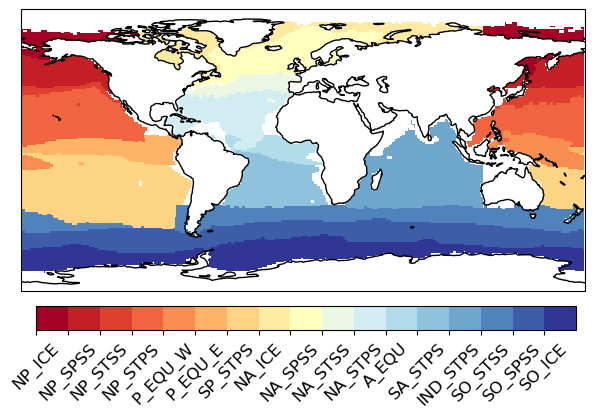

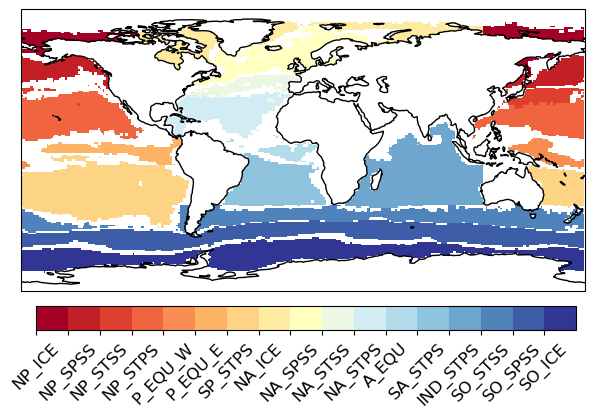

In [28]:
for map_type in ['mean','core']:
    file_out = f'Map_biomes_{map_type}'
    plot_single_map_wmo(dict_bm_maps[map_type],
                        central_longitude=0,
                        vmin=1,
                        vmax=17,
                        nvals=len(bms_labels), #-1,
                        cmap='RdYlBu', #'viridis',
                        cbar=True,
                        ticks=bms_labels,
                        ticks_rotation=45,
                        figsize=(6,6),
                        fig_name=file_out,
                        fig_dir=dir_out,
                        show=True,
                        save=False)

# Align Data to Common Period #

In [29]:
ddata_LE_bfore = {
                   'raw_LE'  : hnd_raw_LE,
                   'nadj_LE' : hnd_nadj_LE
                  }
ddata_em_bfore = {
                     'obs'     : obs,
                     'raw_em'  : hnd_raw_em,                     
                     'nadj_em' : hnd_nadj_em,
                     'em_badj' : hnd_em_badj,
                     'em_tadj' : hnd_em_tadj,
                     'em_nadj' : hnd_em_nadj
                  }

In [30]:
ddata_em_after = {}
for key in ddata_em_bfore.keys():
    ddata_em_after[key] = align_data_to_common_base(ddata_em_bfore[key],
                                                   nldyr=5).sel(year=slice(y0_show,
                                                                           y1_show))

In [31]:
ddata_LE_after = {}
for key in ddata_LE_bfore.keys():
    ddata_LE_after[key] = align_data_to_common_base(ddata_LE_bfore[key],
                                                   nldyr=5).sel(year=slice(y0_show,
                                                                           y1_show))

In [32]:
dict_LE_data = ddata_LE_after
dict_em_data = ddata_em_after

<!-- # Set Data Dictionary # -->

# Set Dict: Clim, Anom and Var (not used) #

In [33]:
dict_clim = {}
for key in dict_em_data.keys():
    dict_clim[key] = get_climatology_on_base(dict_em_data[key],
                                             y0_base,
                                             y1_base,
                                             ltime_dep=False,  # already aligned to target
                                             full_set=False)   # already aligned to target
                                             
dict_anom = {}
for key in dict_em_data.keys():
    dict_anom[key] = dict_em_data[key] - dict_clim[key]

dict_var = {}
for key in dict_em_data.keys():
    dict_var[key] = dict_anom[key].var(dim='year')
# add ensemble variance    
dict_var['raw_LE'] = {
                       'raw_LE'  : (dict_LE_data['raw_LE']-dict_clim['raw_em']).var(dim='year').mean(dim='ensembles'), 
                     }    

<!-- ## Seasonal Cycle: Climatology and Variance ## -->

# Set Dict: Annual Mean and Skill #

In [34]:
list_ds = [
           'obs',
           'raw_em',
           'em_badj',
           'em_tadj',
           'em_nadj',
           'nadj_em',
           ]   
list_ds_type = [
               'full',
               'anom',
               ]

dict_am = {}
dict_am_measures = {}
for ds in list_ds:
    dict_am[ds] = {}
    dict_am_measures[ds] = {}
    for ds_type in list_ds_type:
        if ds_type == 'full':
            data_ds_type = dict_em_data[ds] 
        if ds_type == 'anom':
            data_ds_type = dict_anom[ds] 
            
        dict_am[ds][ds_type] = {} 
        dict_am[ds][ds_type] = write_monthly_to_annual(data_ds_type).sel(year=slice(y0_show,
                                                                                    y1_show))
        dict_am_measures[ds][ds_type] = {} 
        dict_am_measures[ds][ds_type]['corr'] = corr(dict_am['obs'][ds_type],
                                                dict_am[ds][ds_type])
        dict_am_measures[ds][ds_type]['rmse'] = rmse(dict_am['obs'][ds_type],
                                                dict_am[ds][ds_type])

# Set Dict: Avg AM and Skill Over Biomes #

In [35]:
ds_list = [
           'obs', 
           'raw_em',
           'em_badj',
           'em_tadj',
           # 'em_nadj',
           'nadj_em'
          ]

dict_am_biomes = {}

for ii,bm_label in enumerate(bms_labels):

    dict_am_biomes[bm_label] = {}

    biome = biomes.CoreBiomes.where(biomes.CoreBiomes == ii+1)
    mask_ocean = spatial_mask(biome.to_dataset()) # spatial mask    
    
    for ds_type in ['full','anom']:
        
        dict_am_biomes[bm_label][ds_type] = {} 
        
        for ds in ds_list:
            
            dict_am_biomes[bm_label][ds_type][ds] = {} 
            
            # values = area_weighted_avg(dict_am[ds][ds_type],
            #                            mask=mask_ocean)[var]#.values
            values = area_weighted_avg(dict_am[ds][ds_type],
                                       mask=mask_ocean,
                                       integral=True)[var]*toPgCyr#.values
            
            
            dict_am_biomes[bm_label][ds_type][ds] = values        

In [36]:
ds_list = [
           'raw_em',
           'em_badj',
           'em_tadj',
           # 'em_nadj',
           'nadj_em'
          ]

dict_meas_biomes = {}

for ii,bm_label in enumerate(bms_labels):

    dict_meas_biomes[bm_label] = {}

    biome = biomes.CoreBiomes.where(biomes.CoreBiomes == ii+1)
    mask_ocean = spatial_mask(biome.to_dataset()) # spatial mask    
    
    for ds_type in ['full','anom']:
        
        dict_meas_biomes[bm_label][ds_type] = {} 

        for ds_meas in ['corr','rmse']:
            
            dict_meas_biomes[bm_label][ds_type][ds_meas] = {} 
                
            for ds in ds_list:
                
                dict_meas_biomes[bm_label][ds_type][ds_meas][ds] = {} 
        
                values = area_weighted_avg(dict_am_measures[ds][ds_type][ds_meas],
                                          mask=mask_ocean)[var].values
                
                dict_meas_biomes[bm_label][ds_type][ds_meas][ds] = values

## Plots ##

In [37]:
dict_color = {
               'obs'     : obs_dict['color'],
               'raw_em'  : hnd_dict['color'],
               'raw_LE'  : 'tab:blue',
               'em_badj' : 'tab:orange', #'tab:orange', #badj_dict['color'],
               'em_tadj' : tadj_dict['color'],
               'em_nadj' : 'tab:green',
               'nadj_em' : 'tab:green' #nadj_dict['color']
              }

In [38]:
dict_plot_meas = { 'rmse'         : { 
                                      'title'     : '(a)',
                                      'ylabel'    : f'RMSE', # ({units})',
                                      'bbox'      : (.49,.5,.5,.5),
                                      'ylim_min'  : 0.,
                                      'ylim_max'  : 2.3,
                                      'show_leg'  : False,
                                      'show_hline': False    
                                    },                 
                   'corr'         : {
                                      'title'     : '(b)',
                                      'ylabel'    : 'ACC',
                                      'ylim_min'  : -.19,
                                      'ylim_max'  : .8,
                                      'bbox'      : (.06,.5,.5,.5),
                                      'show_leg'  : False,
                                      'show_hline': True   
                                    },
                 }

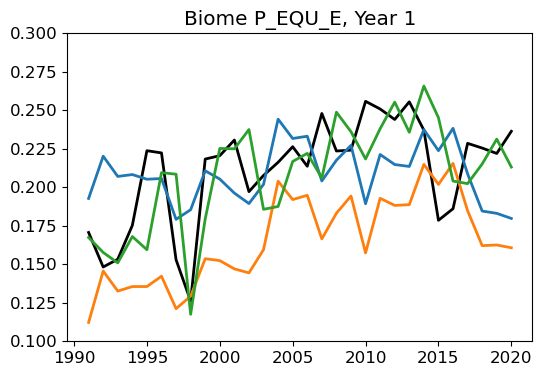

In [39]:
nldyr = 1 #3 #5

ds_type = 'full'

ds_list = [
           'obs',
           'raw_em',
           'em_badj',
           # 'em_tadj',
           # 'em_nadj',
           'nadj_em',
          ]
for ii,bm_label in enumerate(bms_labels):
    
    show = False
    leg = True
    save = False
    if bm_label == 'P_EQU_E':
        show = True
        leg = False
        save = True
    
    for ildyr in np.arange(nldyr-1,nldyr):
        
        ylim_min = min([dict_am_biomes[bm_label][ds_type][ds].sel(time=ildyr).min().values for ds in ds_list])
        ylim_max = max([dict_am_biomes[bm_label][ds_type][ds].sel(time=ildyr).max().values for ds in ds_list])
        
        file_out = f'ts_{ds_type}_biome_{bm_label}_{ildyr+1}-year_lead_{nadj_name}'
        title = f'Biome {bm_label}, Year {ildyr+1}'
        plot_ts_biomes_on_target(ds_list,
                                dict_am_biomes[bm_label][ds_type],
                                ldyr=ildyr,
                                figsize=(6,4),
                                bbox=(.5,.5,.5,.5),
                                color_dict=dict_color,
                                linewidth=2,  
                                axes_linewidth=2,
                                ylim_min=0.1, #ylim_min,
                                ylim_max=0.3, #ylim_max,
                                title=title,
                                leg=leg,
                                dir_name=dir_out,
                                file_name=file_out,
                                show=show,
                                save=save)        

In [40]:
for ii,bm_label in enumerate(bms_labels):
    
    for imeas,meas in enumerate([
                                 'corr',
                                 # 'rmse'
                                ]):
        
        file_out = f'ts_{meas}_biome_{bm_label}_{y0_show}-{y1_show}_{nadj_name}'
        plot_ts_skill([
                       'raw_em',
                       'em_badj',
                       'em_tadj',
                       # 'em_nadj',
                       'nadj_em'
                       ],
                    dict_meas_biomes[bm_label]['full'][meas],        
                    xlim_min=-.2,
                    xlim_max=4.2,
                    ylim_min=bms_dict_plot[ii+1][f'ts_{meas}_avg_ymin'],
                    ylim_max=bms_dict_plot[ii+1][f'ts_{meas}_avg_ymax'],
                    labels = ['raw',
                              'badj',
                              'tadj',
                              # 'nadj*',
                              'nadj'],
                    xlabel='forecast year',
                    ylabel=dict_plot_meas[meas]['ylabel'],
                    color_dict=dict_color,
                    title=f'{bm_label}',
                    bbox=dict_plot_meas[meas]['bbox'],
                    show_leg=dict_plot_meas[meas]['show_leg'],
                    dir_name=dir_out,
                    file_name=file_out,
                    show=False,
                    save=False) 

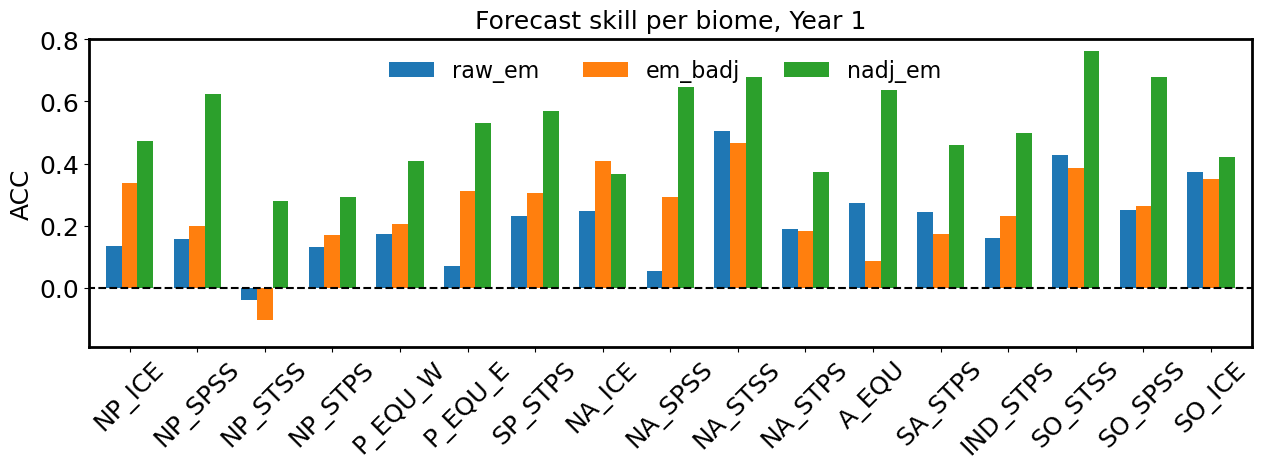

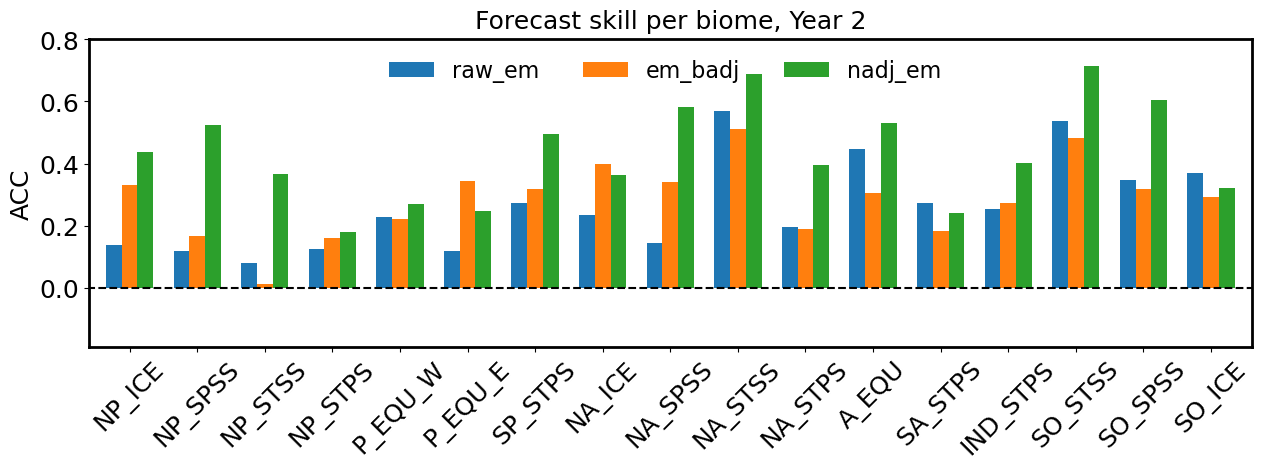

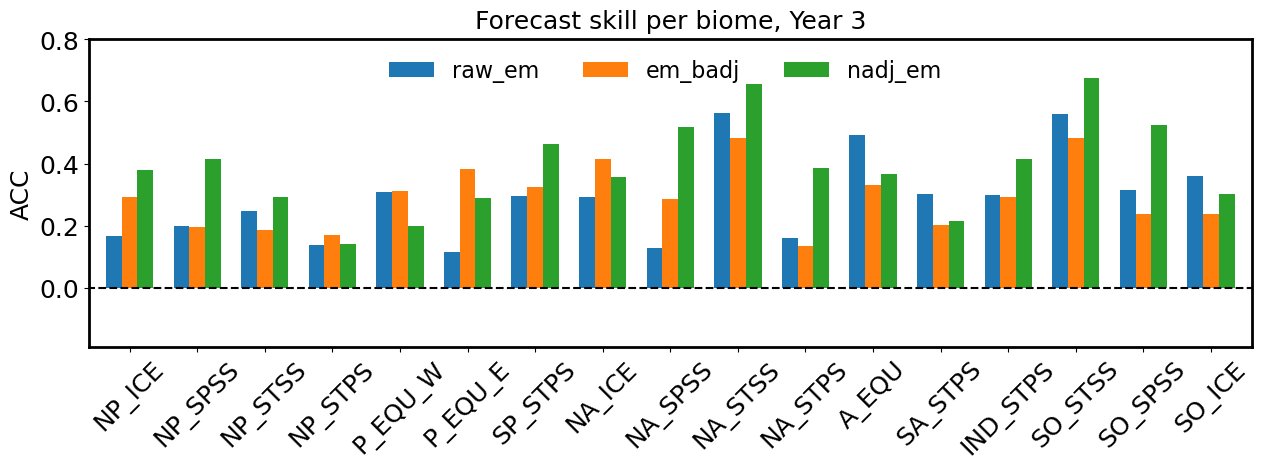

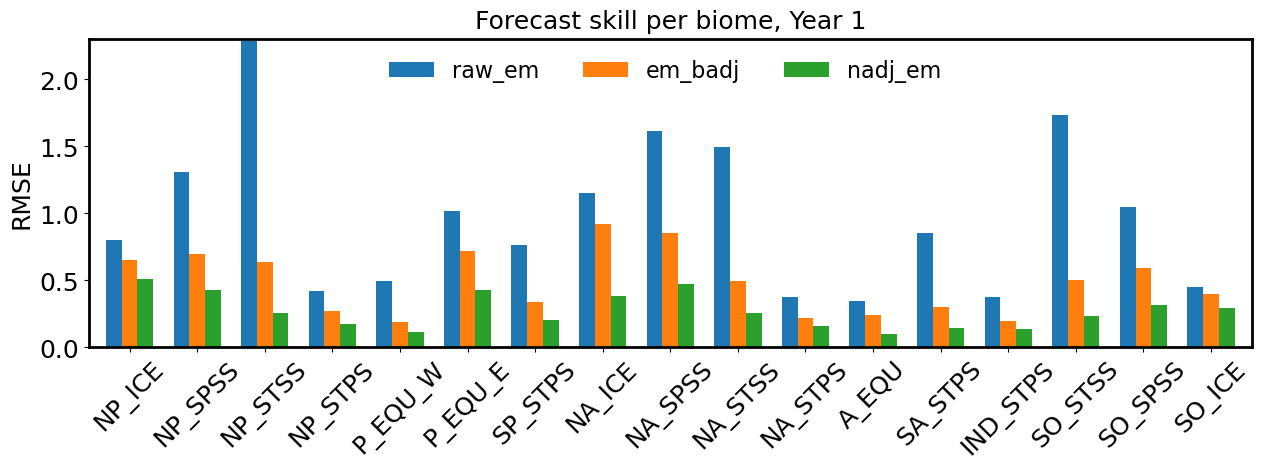

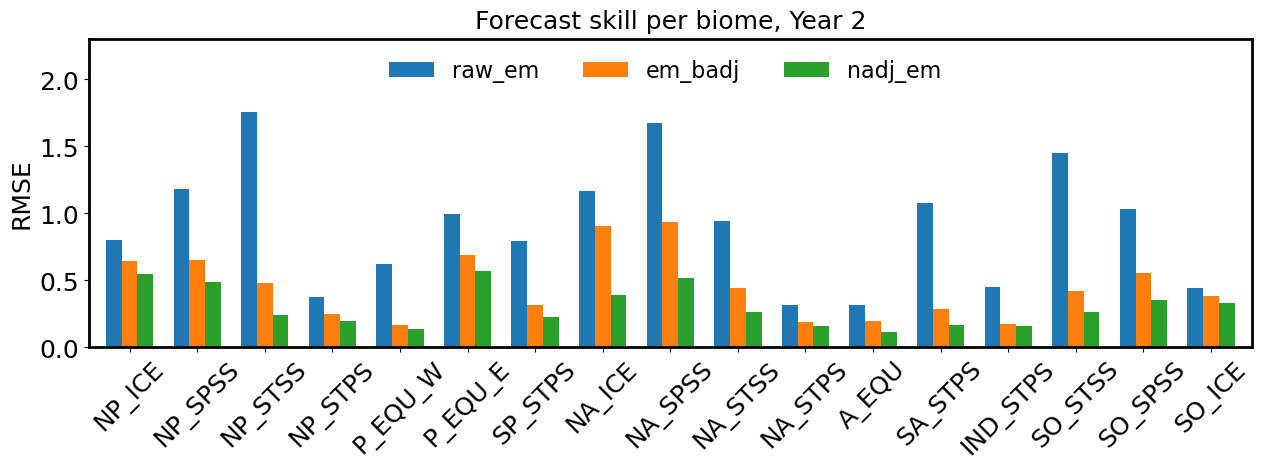

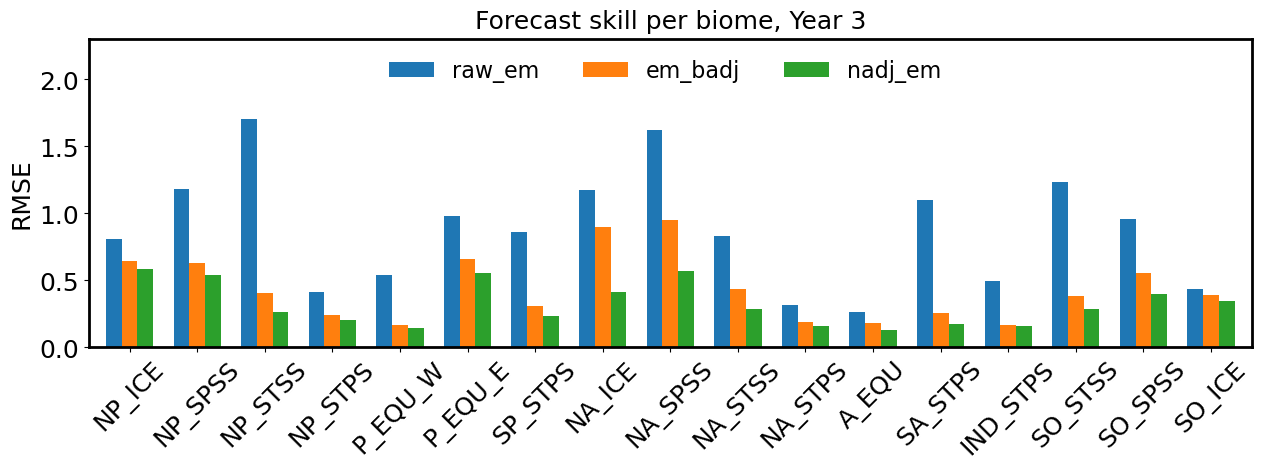

In [41]:
ds_list = [
           'raw_em',
           'em_badj',
           # 'em_tadj',
           # 'em_nadj',
           'nadj_em'
          ]

ds_type = 'full'
nld = 3

for meas in [
             'corr',
             'rmse'
            ]:

    dict_data_to_plot = {}
    for ild in np.arange(nld):
        dict_data_to_plot[ild] = {}
        for ds in ds_list:
            dict_data_to_plot[ild][ds] = {}
            for bm_label in bms_labels:
                dict_data_to_plot[ild][ds][bm_label] = {}
                dict_data_to_plot[ild][ds][bm_label] = dict_meas_biomes[bm_label][ds_type][meas][ds][ild]

    for ild in np.arange(nld):
        
        file_out = f'Barplots_biomes_{meas}_year-{ild+1}_{nadj_name}'
        plot_bars(dict_data_to_plot[ild],
                  title=f'Forecast skill per biome, Year {ild+1}',
                  ylabel=dict_plot_meas[meas]['ylabel'],
                  ylim=(dict_plot_meas[meas]['ylim_min'],
                        dict_plot_meas[meas]['ylim_max']),
                  show_hline=dict_plot_meas[meas]['show_hline'],
                  ncol=3,
                  figsize=(15, 4),
                  leg=True,
                  dir_name=dir_out,
                  file_name=file_out,
                  show=True,
                  save=False)            